In [1]:
from arcgis.gis import GIS
from arcgis.features import FeatureLayer
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import seaborn as sns
import geopandas as gpd
import contextily as ctx
import numpy as np
from scipy.stats import gaussian_kde
import warnings
import json
import urllib.request
import requests
warnings.filterwarnings("ignore")

/Users/nicross/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/nicross/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/nicross/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


# Looking at what is available in the 1 Day Continuous Average Data
[Data Available Here](https://data.cnra.ca.gov/dataset/continuous-groundwater-level-measurements/resource/84e02633-00ca-47e8-97ec-c0093313ddcd) \
2.8 M Measurements, 344 Stations reporting, All NorCal

In [2]:
url = "https://data.cnra.ca.gov/api/3/action/datastore_search"
params = {
    "resource_id": "84e02633-00ca-47e8-97ec-c0093313ddcd",
    "limit": 100000,
    "offset": 0
}

station_stats = {}

def process_chunk(records):
    """Update statistics for each station_id based on a chunk of data."""
    global station_stats

    df = pd.DataFrame(records)

    df['date'] = pd.to_datetime(df['MSMT_DATE'])

    for station_id, group in df.groupby('STATION'):
        dates = group['date'].sort_values()

        if station_id not in station_stats:
            station_stats[station_id] = {
                'earliest_date': dates.iloc[0],
                'latest_date': dates.iloc[-1],
                'total_gap': 0,
                'gap_count': 0
            }
        else:
            station_stats[station_id]['earliest_date'] = min(station_stats[station_id]['earliest_date'], dates.iloc[0])
            station_stats[station_id]['latest_date'] = max(station_stats[station_id]['latest_date'], dates.iloc[-1])

        gaps = dates.diff().dt.days[1:]
        station_stats[station_id]['total_gap'] += gaps.sum()
        station_stats[station_id]['gap_count'] += len(gaps)

while True:
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data.get('success', False):
            records = data['result']['records']
            if not records:
                break

            process_chunk(records)

            params['offset'] += params['limit']
        else:
            print("API call was unsuccessful.")
            break
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        break

final_stats = []
for station_id, stats in station_stats.items():
    avg_gap = stats['total_gap'] / stats['gap_count'] if stats['gap_count'] > 0 else None
    final_stats.append({
        'station_id': station_id,
        'earliest_date': stats['earliest_date'],
        'latest_date': stats['latest_date'],
        'average_gap_days': avg_gap
    })

final_stats_df = pd.DataFrame(final_stats)

The data is pulled 100,000 entries at a time and updates information I have locally stored for each station. Returns information about the earliest and latest entry, also the number of observations.

In [3]:
final_stats_df['length'] = (final_stats_df.latest_date - final_stats_df.earliest_date).dt.days

In [4]:
final_stats_df

,station_id,earliest_date,latest_date,average_gap_days,length
0,01N04E36Q001M,2005-04-30,2020-11-04,1.0,5667
1,01N04E36Q002M,2005-05-28,2019-07-07,1.0,5153
2,01N04E36Q003M,2006-04-29,2019-07-07,1.0,4817
3,01N04E36Q004M,2006-04-29,2019-07-07,1.0,4817
4,01S04E28F001M,2005-04-29,2019-07-07,1.0,5182
...,...,...,...,...,...
352,48N05E14R001M,2001-07-26,2008-11-23,1.0,2677
353,48N05E16P001M,2001-06-30,2013-09-17,1.0,4462
354,48N05E25Q001M,2001-08-17,2003-05-15,1.0,636
355,48N05E26D001M,2001-09-13,2008-11-24,1.0,2629


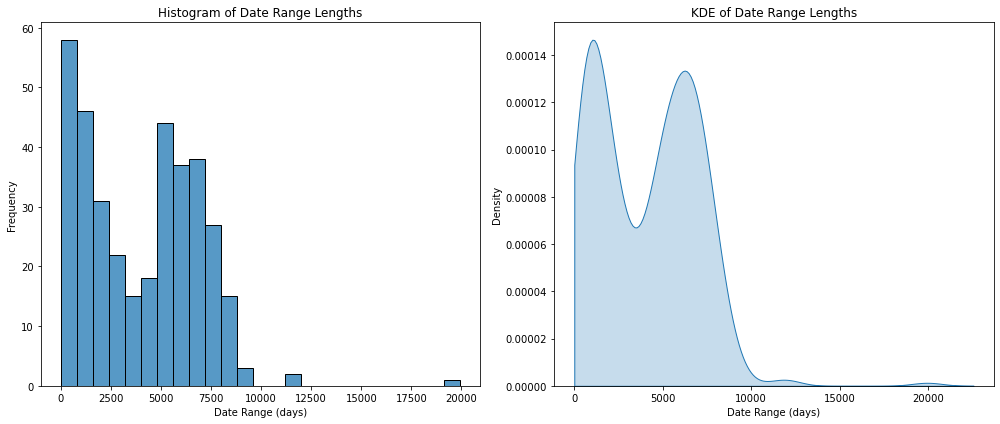

In [5]:
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(final_stats_df['length'], kde=False, bins=25)
plt.title('Histogram of Date Range Lengths')
plt.xlabel('Date Range (days)')
plt.ylabel('Frequency')

# KDE Plot
plt.subplot(1, 2, 2)
sns.kdeplot(final_stats_df['length'], fill=True, clip=(0,None))
plt.title('KDE of Date Range Lengths')
plt.xlabel('Date Range (days)')
plt.ylabel('Density')

# Adjust layout for better appearance
plt.tight_layout()

# Show the plots
plt.show()

In [6]:
url = "https://data.cnra.ca.gov/api/3/action/datastore_search"
params = {
    "resource_id": "03967113-1556-4100-af2c-b16a4d41b9d0",
    "limit": 100000,
    "offset": 0
}
response = requests.get(url, params=params)
data = response.json()['result']['records']
station_mapping = pd.DataFrame(data)

In [7]:
station_mapping.head()

,_id,STATION,SITE_CODE,STNAME,WELL_NAME,LATITUDE,LONGITUDE,LLDATUM,POSACC,ELEV,...,ELEVACC,COUNTY_NAME,BASIN_CODE,BASIN_NAME,WELL_DEPTH,WELL_USE,WELL_TYPE,WCR_NO,WDL,COMMENT
0,1,01N04E36Q001M,378861N1214818W001,Middle River Barrier well 2W screen 61-81 ft bgs,MRL-2W,37.886056,-121.481833,NAD83,"Survey, 1m",6.9,...,R.L. AT SURFACE,San Joaquin,5-022.15,Tracy,81.0,Observation,Single Well,None,https://wdl.water.ca.gov/StationDetails.aspx?S...,01N04E36Q001M is part of a well cluster. Othe...
1,2,01N04E36Q002M,378849N1214822W001,Middle River Barrier well 3W screen 14-34 ft bgs,MRL-3W,37.884861,-121.482167,NAD83,"Survey, 1m",-1.0,...,R.L. AT SURFACE,San Joaquin,5-022.15,Tracy,34.0,Observation,Single Well,None,https://wdl.water.ca.gov/StationDetails.aspx?S...,01N04E36Q002M is part of a well cluster. Othe...
2,3,01N04E36Q003M,378860N1214819W001,Middle River Barrier well 2 screen 10-20 ft bgs,MLNO-2,37.886028,-121.481917,NAD83,"Survey, 1m",8.6,...,R.L. AT SURFACE,San Joaquin,5-022.15,Tracy,20.0,Observation,Single Well,None,https://wdl.water.ca.gov/StationDetails.aspx?S...,01N04E36Q003M is part of a well cluster. Othe...
3,4,01N04E36Q004M,378850N1214820W001,Middle River Barrier well 1 screen 10-20 ft bgs,MLNO-1,37.885028,-121.482000,NAD83,"Survey, 1m",15.9,...,R.L. AT SURFACE,San Joaquin,5-022.15,Tracy,20.0,Observation,Single Well,None,https://wdl.water.ca.gov/StationDetails.aspx?S...,01N04E36Q004M is part of a well cluster. Othe...
4,5,01S04E28F001M,378186N1215443W001,Grant Line Canal Barrier well 2W screen 10-25 ...,GLWL-2W,37.818556,-121.544333,NAD83,"Survey, 1m",16.1,...,R.L. AT SURFACE,San Joaquin,5-022.15,Tracy,25.0,Observation,Single Well,None,https://wdl.water.ca.gov/StationDetails.aspx?S...,01S04E28F001M is part of a well cluster. Othe...


In [8]:
stats_locations = final_stats_df.merge(station_mapping, left_on="station_id", right_on="STATION")

In [9]:
stats_locations.head()

,station_id,earliest_date,latest_date,average_gap_days,length,_id,STATION,SITE_CODE,STNAME,WELL_NAME,...,ELEVACC,COUNTY_NAME,BASIN_CODE,BASIN_NAME,WELL_DEPTH,WELL_USE,WELL_TYPE,WCR_NO,WDL,COMMENT
0,01N04E36Q001M,2005-04-30,2020-11-04,1.0,5667,1,01N04E36Q001M,378861N1214818W001,Middle River Barrier well 2W screen 61-81 ft bgs,MRL-2W,...,R.L. AT SURFACE,San Joaquin,5-022.15,Tracy,81.0,Observation,Single Well,None,https://wdl.water.ca.gov/StationDetails.aspx?S...,01N04E36Q001M is part of a well cluster. Othe...
1,01N04E36Q002M,2005-05-28,2019-07-07,1.0,5153,2,01N04E36Q002M,378849N1214822W001,Middle River Barrier well 3W screen 14-34 ft bgs,MRL-3W,...,R.L. AT SURFACE,San Joaquin,5-022.15,Tracy,34.0,Observation,Single Well,None,https://wdl.water.ca.gov/StationDetails.aspx?S...,01N04E36Q002M is part of a well cluster. Othe...
2,01N04E36Q003M,2006-04-29,2019-07-07,1.0,4817,3,01N04E36Q003M,378860N1214819W001,Middle River Barrier well 2 screen 10-20 ft bgs,MLNO-2,...,R.L. AT SURFACE,San Joaquin,5-022.15,Tracy,20.0,Observation,Single Well,None,https://wdl.water.ca.gov/StationDetails.aspx?S...,01N04E36Q003M is part of a well cluster. Othe...
3,01N04E36Q004M,2006-04-29,2019-07-07,1.0,4817,4,01N04E36Q004M,378850N1214820W001,Middle River Barrier well 1 screen 10-20 ft bgs,MLNO-1,...,R.L. AT SURFACE,San Joaquin,5-022.15,Tracy,20.0,Observation,Single Well,None,https://wdl.water.ca.gov/StationDetails.aspx?S...,01N04E36Q004M is part of a well cluster. Othe...
4,01S04E28F001M,2005-04-29,2019-07-07,1.0,5182,5,01S04E28F001M,378186N1215443W001,Grant Line Canal Barrier well 2W screen 10-25 ...,GLWL-2W,...,R.L. AT SURFACE,San Joaquin,5-022.15,Tracy,25.0,Observation,Single Well,None,https://wdl.water.ca.gov/StationDetails.aspx?S...,01S04E28F001M is part of a well cluster. Othe...


In [10]:
stats_loc_geo = gpd.GeoDataFrame(stats_locations, 
                                geometry=gpd.points_from_xy(stats_locations['LONGITUDE'], stats_locations['LATITUDE']),
                                crs="EPSG:4326")
stats_loc_geo.to_crs(epsg=3857, inplace=True)
today = datetime.today()
stats_loc_geo['days_since_today'] = (today - stats_loc_geo['latest_date']).dt.days

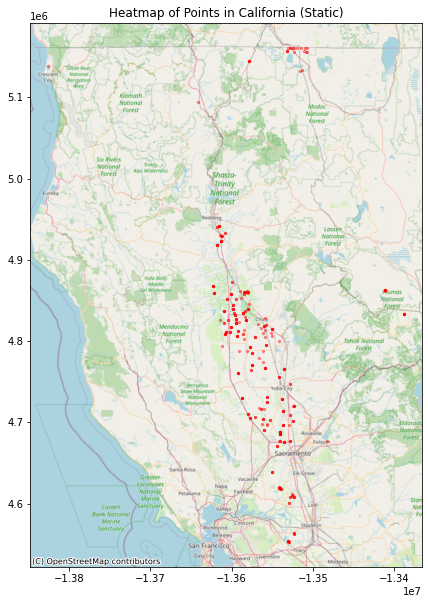

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
stats_loc_geo.plot(markersize=5, figsize=(10, 8), color="red", alpha=0.4, ax=ax)
ctx.add_basemap(ax, crs=stats_loc_geo.crs, source=ctx.providers.OpenStreetMap.Mapnik)
plt.title("Heatmap of Points in California (Static)")
plt.show()

In [12]:
stats_loc_geo['latest_date'] = pd.to_datetime(stats_loc_geo['latest_date'])
buffer_distance = 10 * 1609.34

def calculate_min_days_for_point(point, gdf):
    buffer = point.buffer(buffer_distance)
    neighbors = gdf[gdf.geometry.within(buffer)]
    return neighbors['days_since_today'].min()

stats_loc_geo['10_mile_min_days'] = stats_loc_geo.apply(lambda row: calculate_min_days_for_point(row.geometry, stats_loc_geo), axis=1)

Using a 10 mile clustering, idea is that if one well stops reporting but another nearby continues then there is still data available for the area.

In [13]:
stats_loc_geo.head()

,station_id,earliest_date,latest_date,average_gap_days,length,_id,STATION,SITE_CODE,STNAME,WELL_NAME,...,BASIN_NAME,WELL_DEPTH,WELL_USE,WELL_TYPE,WCR_NO,WDL,COMMENT,geometry,days_since_today,10_mile_min_days
0,01N04E36Q001M,2005-04-30,2020-11-04,1.0,5667,1,01N04E36Q001M,378861N1214818W001,Middle River Barrier well 2W screen 61-81 ft bgs,MRL-2W,...,Tracy,81.0,Observation,Single Well,None,https://wdl.water.ca.gov/StationDetails.aspx?S...,01N04E36Q001M is part of a well cluster. Othe...,POINT (-13523295.827 4563341.766),1480,1480
1,01N04E36Q002M,2005-05-28,2019-07-07,1.0,5153,2,01N04E36Q002M,378849N1214822W001,Middle River Barrier well 3W screen 14-34 ft bgs,MRL-3W,...,Tracy,34.0,Observation,Single Well,None,https://wdl.water.ca.gov/StationDetails.aspx?S...,01N04E36Q002M is part of a well cluster. Othe...,POINT (-13523332.934 4563173.294),1966,1480
2,01N04E36Q003M,2006-04-29,2019-07-07,1.0,4817,3,01N04E36Q003M,378860N1214819W001,Middle River Barrier well 2 screen 10-20 ft bgs,MLNO-2,...,Tracy,20.0,Observation,Single Well,None,https://wdl.water.ca.gov/StationDetails.aspx?S...,01N04E36Q003M is part of a well cluster. Othe...,POINT (-13523305.104 4563337.848),1966,1480
3,01N04E36Q004M,2006-04-29,2019-07-07,1.0,4817,4,01N04E36Q004M,378850N1214820W001,Middle River Barrier well 1 screen 10-20 ft bgs,MLNO-1,...,Tracy,20.0,Observation,Single Well,None,https://wdl.water.ca.gov/StationDetails.aspx?S...,01N04E36Q004M is part of a well cluster. Othe...,POINT (-13523314.381 4563196.802),1966,1480
4,01S04E28F001M,2005-04-29,2019-07-07,1.0,5182,5,01S04E28F001M,378186N1215443W001,Grant Line Canal Barrier well 2W screen 10-25 ...,GLWL-2W,...,Tracy,25.0,Observation,Single Well,None,https://wdl.water.ca.gov/StationDetails.aspx?S...,01S04E28F001M is part of a well cluster. Othe...,POINT (-13530253.295 4553825.413),1966,1480


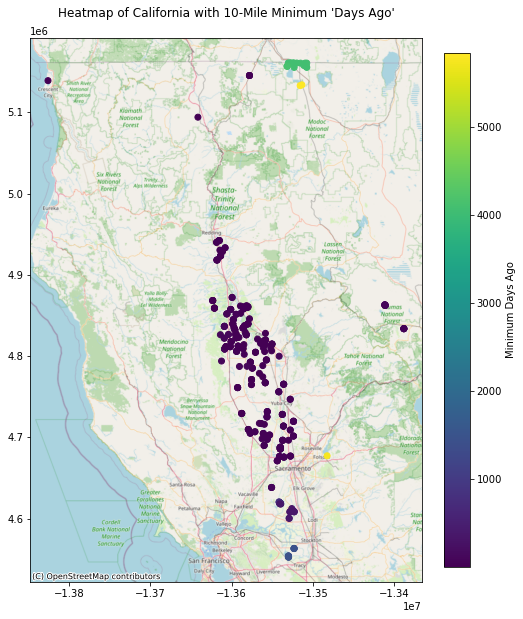

In [14]:
norm = plt.Normalize(vmin=stats_loc_geo['10_mile_min_days'].min(), vmax=stats_loc_geo['10_mile_min_days'].max())

fig, ax = plt.subplots(figsize=(10, 10))
stats_loc_geo.plot(column='10_mile_min_days', cmap="viridis", norm=norm, ax=ax, legend=False)  # Disable automatic legend
ctx.add_basemap(ax, crs=stats_loc_geo.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Heatmap of California with 10-Mile Minimum 'Days Ago'\n")

sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Minimum Days Ago')

plt.show()

In [15]:
def calculate_total_days_for_point(point, gdf):
    '''Calculates total days available for a cluster adjusted by interval overlap'''
    buffer = point.buffer(buffer_distance)
    neighbours = gdf[gdf.geometry.within(buffer)]
    neighbours = neighbours.sort_values(by="earliest_date").reset_index(drop=True)
    merged_intervals = []
    current_start = neighbours.loc[0, "earliest_date"]
    current_end = neighbours.loc[0, "latest_date"]
    for i in range(1, len(neighbours)):
        start = neighbours.loc[i, "earliest_date"]
        end = neighbours.loc[i, "latest_date"]
        if start <= current_end:  # Overlap
            current_end = max(current_end, end)
        else:  # No overlap
            merged_intervals.append((current_start, current_end))
            current_start = start
            current_end = end
    merged_intervals.append((current_start, current_end))
    merged_length = sum((end - start).days + 1 for start, end in merged_intervals)
    total_length = neighbours["length"].sum()
    adjusted_length = total_length - (total_length - merged_length)
    return adjusted_length
    
stats_loc_geo['10_mile_days_available'] = stats_loc_geo.apply(lambda row: calculate_total_days_for_point(row.geometry, stats_loc_geo), axis=1)

This looks at how many days of data total are available for a 10 mile radius, it is adjusted so as not to 'double count' days. For example, if we have two stations 1 mile apart that both reported on 1 Jan 2024, then this function would only count that as 1 day of available data for the 10mi cluster.

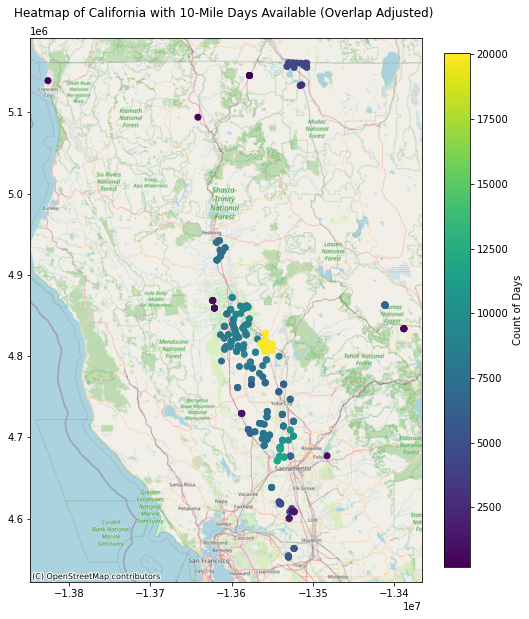

In [16]:
norm = plt.Normalize(vmin=stats_loc_geo['10_mile_days_available'].min(), vmax=stats_loc_geo['10_mile_days_available'].max())

fig, ax = plt.subplots(figsize=(10, 10))
stats_loc_geo.plot(column='10_mile_days_available', cmap="viridis", norm=norm, ax=ax, legend=False)  # Disable automatic legend
ctx.add_basemap(ax, crs=stats_loc_geo.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title("Heatmap of California with 10-Mile Days Available (Overlap Adjusted) \n")

sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Count of Days')

plt.show()

# Looking at the Peridodic Data

[Data available here](https://data.cnra.ca.gov/dataset/periodic-groundwater-level-measurements/resource/bfa9f262-24a1-45bd-8dc8-138bc8107266) \
5.7M entries

In [2]:
url = "https://data.cnra.ca.gov/api/3/action/datastore_search"
params = {
    "resource_id": "bfa9f262-24a1-45bd-8dc8-138bc8107266",
    "limit": 100000,
    "offset": 0
}

station_stats = {}

def process_chunk(records):
    """Update statistics for each station_id based on a chunk of data."""
    global station_stats

    df = pd.DataFrame(records)

    df['date'] = pd.to_datetime(df['msmt_date'])

    for station_id, group in df.groupby('site_code'):
        dates = group['date'].sort_values()

        if station_id not in station_stats:
            station_stats[station_id] = {
                'earliest_date': dates.iloc[0],
                'latest_date': dates.iloc[-1],
                'total_gap': 0,
                'gap_count': 0
            }
        else:
            station_stats[station_id]['earliest_date'] = min(station_stats[station_id]['earliest_date'], dates.iloc[0])
            station_stats[station_id]['latest_date'] = max(station_stats[station_id]['latest_date'], dates.iloc[-1])

        gaps = dates.diff().dt.days[1:]
        station_stats[station_id]['total_gap'] += gaps.sum()
        station_stats[station_id]['gap_count'] += len(gaps)

while True:
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        if data.get('success', False):
            records = data['result']['records']
            if not records:
                break

            process_chunk(records)

            params['offset'] += params['limit']
        else:
            print("API call was unsuccessful.")
            break
    else:
        print(f"Failed to retrieve data. Status code: {response.status_code}")
        break

final_stats = []
for station_id, stats in station_stats.items():
    avg_gap = stats['total_gap'] / stats['gap_count'] if stats['gap_count'] > 0 else None
    final_stats.append({
        'station_id': station_id,
        'earliest_date': stats['earliest_date'],
        'latest_date': stats['latest_date'],
        'average_gap_days': avg_gap
    })

final_stats_df = pd.DataFrame(final_stats)
final_stats_df = final_stats_df[final_stats_df["average_gap_days"] > 0] # trim 1 day observations to avoid inf issues

In [3]:
final_stats_df

,station_id,earliest_date,latest_date,average_gap_days
0,320000N1140000W001,2016-01-28,2024-05-30,60.840000
1,325450N1171061W001,2005-09-01,2010-09-22,123.133333
2,325450N1171061W002,2005-09-01,2010-09-22,131.928571
3,325450N1171061W003,2005-09-01,2010-09-22,131.928571
4,325450N1171061W004,2005-09-01,2010-09-22,131.928571
...,...,...,...,...
23244,412029N1211588W001,2023-01-27,2024-08-12,1.458549
23245,412030N1211579W001,2023-06-09,2024-08-12,1.028708
23246,412035N1211578W001,2023-01-27,2024-08-12,1.112648
23247,412110N1210287W001,2020-03-28,2024-08-12,1.152127


In [4]:
url = "https://data.cnra.ca.gov/api/3/action/datastore_search"
params = {
    "resource_id": "af157380-fb42-4abf-b72a-6f9f98868077",
    "limit": 100000,
    "offset": 0
}
response = requests.get(url, params=params)
data = response.json()['result']['records']
station_mapping = pd.DataFrame(data)

In [5]:
station_mapping.head()

,_id,site_code,stn_id,swn,well_name,continuous_data_station_number,latitude,longitude,gse,rpe,gse_method,gse_acc,basin_code,basin_name,county_name,well_depth,well_use,well_type,wcr_no,monitoring_program
0,1,320000N1140000W001,51445,None,Bay Ridge,None,36.56048,-121.75463,545.92,545.92,Unknown,Unknown,None,None,Monterey,386.0,Residential,Part of a nested/multi-completion well,None,VOLUNTARY
1,2,325450N1171061W001,25067,19S02W05K003S,19S02W05K003S,None,32.54500,-117.10610,17.14,17.14,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,None,VOLUNTARY
2,3,325450N1171061W002,25068,19S02W05K004S,19S02W05K004S,None,32.54500,-117.10610,17.14,17.14,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,None,VOLUNTARY
3,4,325450N1171061W003,39833,19S02W05K005S,19S02W05K005S,None,32.54500,-117.10610,17.14,17.14,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,None,VOLUNTARY
4,5,325450N1171061W004,25069,19S02W05K006S,19S02W05K006S,None,32.54500,-117.10610,17.14,17.14,Unknown,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,None,VOLUNTARY


In [6]:
periodic = final_stats_df.merge(station_mapping, left_on="station_id", right_on="site_code")

In [7]:
periodic_gpd = gpd.GeoDataFrame(periodic, 
                                geometry=gpd.points_from_xy(periodic['longitude'], periodic['latitude']),
                                crs="EPSG:4326")
periodic_gpd.to_crs(epsg=3857, inplace=True)

In [8]:
periodic_gpd

,station_id,earliest_date,latest_date,average_gap_days,_id,site_code,stn_id,swn,well_name,continuous_data_station_number,...,gse_acc,basin_code,basin_name,county_name,well_depth,well_use,well_type,wcr_no,monitoring_program,geometry
0,320000N1140000W001,2016-01-28,2024-05-30,60.840000,1,320000N1140000W001,51445,None,Bay Ridge,None,...,Unknown,None,None,Monterey,386.0,Residential,Part of a nested/multi-completion well,None,VOLUNTARY,POINT (-13553663.413 4378019.160)
1,325450N1171061W001,2005-09-01,2010-09-22,123.133333,2,325450N1171061W001,25067,19S02W05K003S,19S02W05K003S,None,...,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,None,VOLUNTARY,POINT (-13036191.421 3835064.888)
2,325450N1171061W002,2005-09-01,2010-09-22,131.928571,3,325450N1171061W002,25068,19S02W05K004S,19S02W05K004S,None,...,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,None,VOLUNTARY,POINT (-13036191.421 3835064.888)
3,325450N1171061W003,2005-09-01,2010-09-22,131.928571,4,325450N1171061W003,39833,19S02W05K005S,19S02W05K005S,None,...,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,None,VOLUNTARY,POINT (-13036191.421 3835064.888)
4,325450N1171061W004,2005-09-01,2010-09-22,131.928571,5,325450N1171061W004,25069,19S02W05K006S,19S02W05K006S,None,...,Unknown,9-033,Coastal Plain Of San Diego,San Diego,NaN,Unknown,Unknown,None,VOLUNTARY,POINT (-13036191.421 3835064.888)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23244,412029N1211588W001,2023-01-27,2024-08-12,1.458549,46513,412029N1211588W001,55628,39N07E22M005M,BVMW 4-2,39N07E22M005M,...,0.1 ft.,5-004,Big Valley,Lassen,74.0,Observation,Single Well,WCR2019-017362,SGMA,POINT (-13487334.808 5042320.028)
23245,412030N1211579W001,2023-06-09,2024-08-12,1.028708,46514,412030N1211579W001,55629,39N07E22M004M,BVMW 4-3,39N07E22M004M,...,0.1 ft.,5-004,Big Valley,Lassen,80.0,Observation,Single Well,WCR2019-017361,SGMA,POINT (-13487231.281 5042328.906)
23246,412035N1211578W001,2023-01-27,2024-08-12,1.112648,46515,412035N1211578W001,55630,39N07E22M003M,BVMW 4-4,39N07E22M003M,...,0.1 ft.,5-004,Big Valley,Lassen,93.0,Observation,Single Well,WCR2019-017360,SGMA,POINT (-13487229.054 5042410.282)
23247,412110N1210287W001,2020-03-28,2024-08-12,1.152127,46518,412110N1210287W001,55621,39N08E23D003M,BVMW 2-3,39N08E23D003M,...,0.1 ft.,5-004,Big Valley,Lassen,70.0,Observation,Single Well,WCR2020-006674,SGMA,POINT (-13472851.029 5043506.710)


In [9]:
buffer_distance = 10 * 1609.34

def min_avg_gap(row, gdf):
    buffer = row.geometry.buffer(buffer_distance)
    neighbours = gdf[gdf.geometry.within(buffer)]
    return neighbours.average_gap_days.min()

In [10]:
periodic_gpd["10mi_min_avg_gap"] = periodic_gpd.apply(lambda row: min_avg_gap(row, periodic_gpd), axis=1)

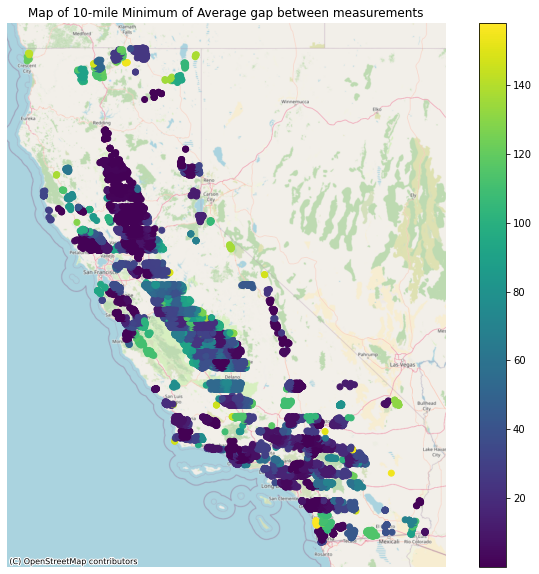

In [11]:
fig, ax = plt.subplots(figsize=(12, 10))
periodic_gpd[(periodic_gpd["10mi_min_avg_gap"] < periodic_gpd["10mi_min_avg_gap"].quantile(0.975)) &
            (periodic_gpd["10mi_min_avg_gap"] > periodic_gpd["10mi_min_avg_gap"].quantile(0.025))
            ].plot(column="10mi_min_avg_gap", legend=True, ax=ax, cmap='viridis') # trimmed for middle 95% of data
ctx.add_basemap(ax, crs=periodic_gpd.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title(f"Map of 10-mile Minimum of Average gap between measurements")
plt.axis('off')
plt.show()

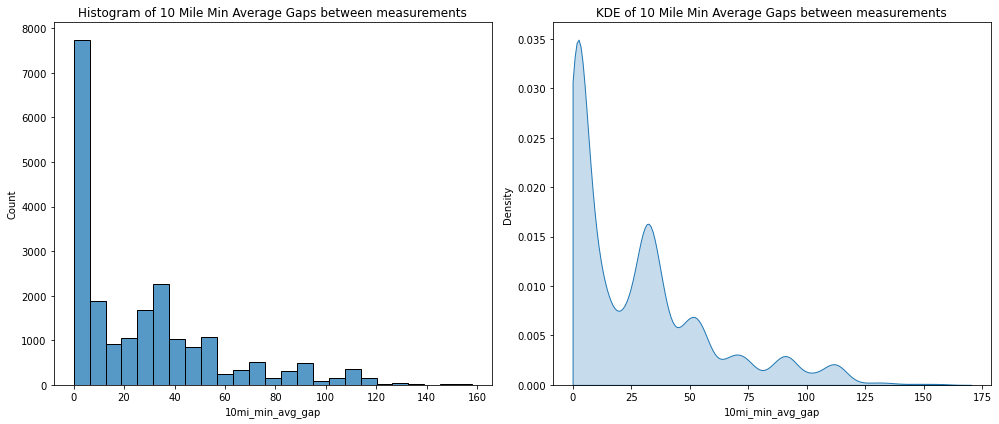

In [12]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(periodic_gpd[(periodic_gpd["10mi_min_avg_gap"] < periodic_gpd["10mi_min_avg_gap"].quantile(0.975)) &
            (periodic_gpd["10mi_min_avg_gap"] > periodic_gpd["10mi_min_avg_gap"].quantile(0.025))
            ]["10mi_min_avg_gap"], bins=25)
plt.title("Histogram of 10 Mile Min Average Gaps between measurements")

plt.subplot(1, 2, 2)
sns.kdeplot(periodic_gpd[(periodic_gpd["10mi_min_avg_gap"] < periodic_gpd["10mi_min_avg_gap"].quantile(0.975)) &
            (periodic_gpd["10mi_min_avg_gap"] > periodic_gpd["10mi_min_avg_gap"].quantile(0.025))
            ]["10mi_min_avg_gap"], clip=(0,None), fill=True)
plt.title("KDE of 10 Mile Min Average Gaps between measurements")

plt.tight_layout()

plt.show()

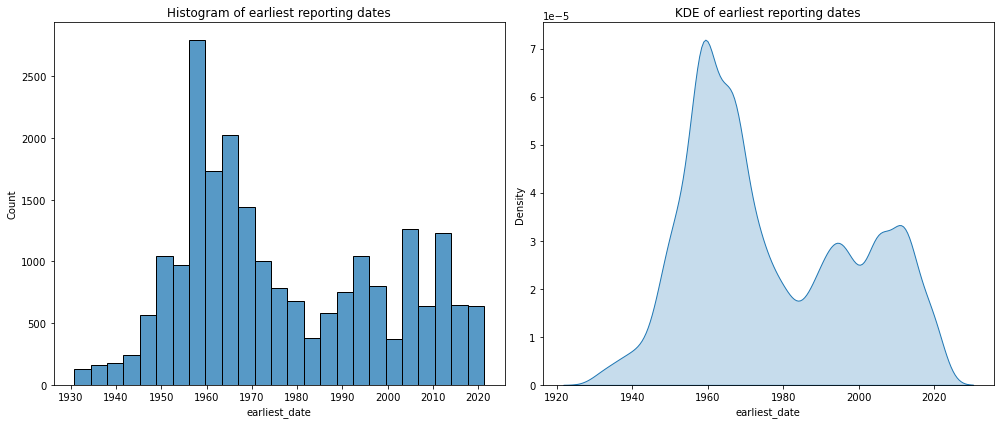

In [13]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(periodic_gpd[(periodic_gpd["earliest_date"] < periodic_gpd["earliest_date"].quantile(0.975)) &
            (periodic_gpd["earliest_date"] > periodic_gpd["earliest_date"].quantile(0.025))
            ]["earliest_date"], bins=25)
plt.title("Histogram of earliest reporting dates")

plt.subplot(1, 2, 2)
sns.kdeplot(periodic_gpd[(periodic_gpd["earliest_date"] < periodic_gpd["earliest_date"].quantile(0.975)) &
            (periodic_gpd["earliest_date"] > periodic_gpd["earliest_date"].quantile(0.025))
            ]["earliest_date"], fill=True)
plt.title("KDE of earliest reporting dates")

plt.tight_layout()

plt.show()

In [106]:
year_freq = {}
for year in list(range(periodic.earliest_date.min().year, periodic.latest_date.max().year)):
    year_freq[year] = 0

def year_reporting_depth(row):
    global year_freq
    if row.average_gap_days > periodic_gpd.average_gap_days.quantile(0.975):
        return
    span = list(range(row.earliest_date.year, row.latest_date.year + 1))
    for year in span:
        year_freq[year] = year_freq.get(year, 0) + (365 / row.average_gap_days)

In [107]:
periodic_gpd.apply(year_reporting_depth, axis=1)

0        None
1        None
2        None
3        None
4        None
         ... 
23244    None
23245    None
23246    None
23247    None
23248    None
Length: 18377, dtype: object

In [108]:
years_periodic = pd.DataFrame(list(year_freq.items()), columns=["Year", "Count"])

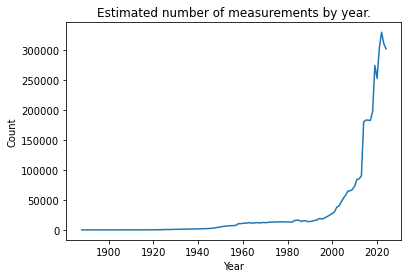

In [109]:
sns.lineplot(data=years_periodic, x="Year", y="Count")
plt.title("Estimated number of measurements by year.")
plt.show()

The above is an estimate based on the reporting date range of all stations in the set, an exact distribution can be calculated but requires more computation as all ~6 Mn records must be accounted.

Now looking at the 10mi locations of wells for which there is data that covers between 2010 and 2020.

In [64]:
buffer_distance = 10 * 1609.34

def meets_2010_2020(row, gdf):
    buffer = row.geometry.buffer(buffer_distance)
    neighbours = gdf[(gdf.geometry.within(buffer)) & (gdf.average_gap_days < 365)]
    year_range = range(2010, 2021)
    for year in year_range:
        filtered = neighbours[(neighbours.earliest_date.dt.year <= year) | (neighbours.latest_date.dt.year >= year)]
        if len(filtered) == 0:
            return False
    return True

In [65]:
periodic_gpd["2010_2020?"] = periodic_gpd.apply(lambda row: meets_2010_2020(row, periodic_gpd), axis=1)

### Logic for 10mi avg 2010_2020

If a station has an average gap of 365 days then it reports once a year in expectation. Therefore if there are two stations with 365 day gaps, then I expect 2 observations for the year.

- 365/avg_gap to get the number of expected observations for each station that year
- sum the number of observations across the range 2010 to 2020
- find the expected number of observations per year

In [103]:
def find_10mi_avg_obs_sub365_2010_2020(row, gdf):
    if not row["2010_2020?"]:
        return -1
    buffer = row.geometry.buffer(buffer_distance)
    neighbours = gdf[(gdf.geometry.within(buffer)) & (gdf.average_gap_days < 365)]
    total = 0
    year_range = range(2010, 2021)
    for year in year_range:
        filtered = neighbours[(neighbours.earliest_date.dt.year <= year) | (neighbours.latest_date.dt.year >= year)]
        expected_obs = sum(365 / filtered.average_gap_days)
        total += expected_obs
    return total / 11

In [104]:
periodic_gpd["10mi_sub365_avg_obs"] = periodic_gpd.apply(lambda row: find_10mi_avg_obs_sub365_2010_2020(row, periodic_gpd), axis=1)

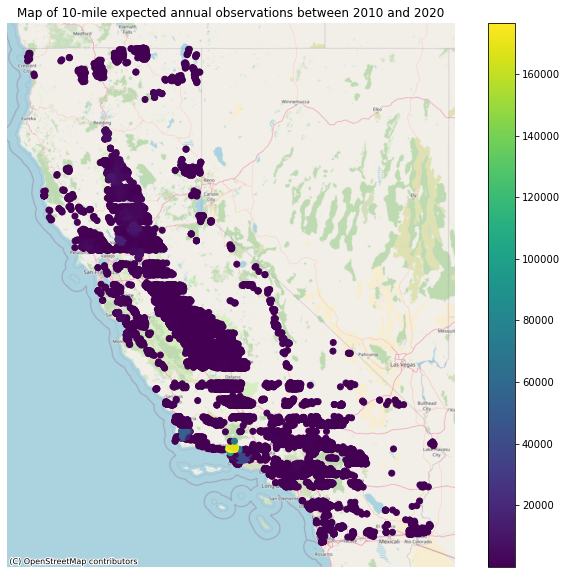

In [112]:
fig, ax = plt.subplots(figsize=(12, 10))
periodic_gpd[periodic_gpd["2010_2020?"]].plot(column="10mi_sub365_avg_obs", legend=True, ax=ax, cmap='viridis')
ctx.add_basemap(ax, crs=periodic_gpd.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title(f"Map of 10-mile expected annual observations between 2010 and 2020")
plt.axis('off')
plt.show()

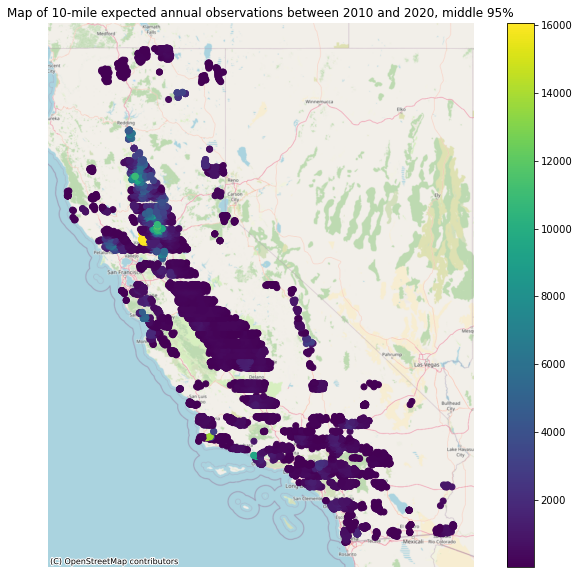

In [114]:
fig, ax = plt.subplots(figsize=(12, 10))
periodic_gpd[(periodic_gpd["2010_2020?"])
            & (periodic_gpd["10mi_sub365_avg_obs"] < periodic_gpd["10mi_sub365_avg_obs"].quantile(0.975))
            & (periodic_gpd["10mi_sub365_avg_obs"] > periodic_gpd["10mi_sub365_avg_obs"].quantile(0.025))
            ].plot(column="10mi_sub365_avg_obs", legend=True, ax=ax, cmap='viridis') # trimmed for middle 95% of data
ctx.add_basemap(ax, crs=periodic_gpd.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title(f"Map of 10-mile expected annual observations between 2010 and 2020, middle 95%")
plt.axis('off')
plt.show()

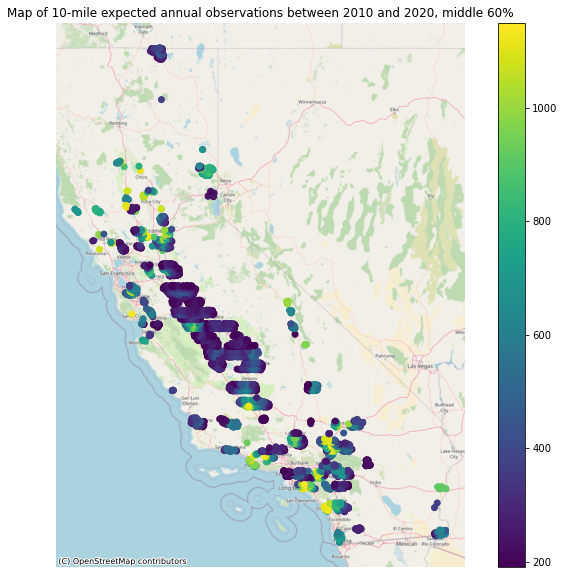

In [117]:
fig, ax = plt.subplots(figsize=(12, 10))
periodic_gpd[(periodic_gpd["2010_2020?"])
            & (periodic_gpd["10mi_sub365_avg_obs"] < periodic_gpd["10mi_sub365_avg_obs"].quantile(0.8))
            & (periodic_gpd["10mi_sub365_avg_obs"] > periodic_gpd["10mi_sub365_avg_obs"].quantile(0.2))
            ].plot(column="10mi_sub365_avg_obs", legend=True, ax=ax, cmap='viridis')
ctx.add_basemap(ax, crs=periodic_gpd.crs, source=ctx.providers.OpenStreetMap.Mapnik)
ax.set_title(f"Map of 10-mile expected annual observations between 2010 and 2020, middle 60%")
plt.axis('off')
plt.show()

In [123]:
periodic_gpd[periodic_gpd["2010_2020?"]].well_depth.isna().sum() / len(periodic_gpd[periodic_gpd["2010_2020?"]])

0.608562857922007